<a href="https://colab.research.google.com/github/tristantoupin/ECSE415-FinalProject/blob/master/SVM_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifer

In [2]:
import numpy as np
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
import os
import math
import itertools

from skimage.feature import hog
from joblib import dump, load
from sklearn.ensemble import BaggingClassifier

path_classification = './MIO-TCD-Classification'

## Helper functions for image plotting, importing, and preprocessing

In [3]:
def plot_images(list_of_images, max_col = 4):
    """
    @brief Plot a list of given images with
    @param list_of_images List of images to plot
    @param max_col Number of colomns to plot your figures
    """
    n = len(list_of_images)
    if n == 1:
        plt.imshow(list_of_images[0]); plt.axis('off'); plt.show()
    else:
        # get number of columns and rows required
        r, c = 1, n
        if n > max_col:
            c = max_col
            r = int(math.ceil(n/max_col))
    
        fig = plt.figure(figsize=(17, max_col * r))
        for i, (img) in enumerate(list_of_images):
            ax = fig.add_subplot(r, c, (i+1))
            ax.set_title("Image " + str(i))
            ax.axis('off')
            ax.imshow(img, cmap=plt.cm.gray)

In [4]:
def pad_resize_images(img_list, output_size):
    """
    @brief Resize each image within a list to a given shape while also keeping its aspect ratio by the use of padding
    @param img_list The list of images to resize
    @param output_size The shape of the output images are output_size x output_size
    """
    BLACK = 0
    result = np.empty_like(img_list)
    
    for i, img in enumerate(img_list):
        
        height, width = img.shape
        ratio = float(output_size) / max([height, width])
        height_new, width_new = tuple([int(val * ratio) for val in (height, width)])
        img_resized = cv2.resize(img, (height_new, width_new))
        
        height_adjust = output_size - height_new
        width_adjust = output_size - width_new
        
        top = math.ceil(height_adjust / 2)
        bot = height_adjust - top
        left = math.ceil(width_adjust / 2)
        right = width_adjust - left
        
        result[i] = cv2.resize(
            cv2.copyMakeBorder(img_resized, top, bot, left, right, cv2.BORDER_CONSTANT, value=BLACK),
            (output_size, output_size))
    return result

In [5]:
def fine_tune_svm(x_tr, y_tr, folds=10):
    """
    @brief Trains, fine tunes, and returns a set of models at different parameters, prints the best parameters possible
    @param x_tr Training vectors
    @param y_tr Target vector
    @param folds Number of folds for grid search cross validation
    """
    tuned_parameters = [{'kernel': ['rbf'], 
                            'gamma': [1e-3, 1e-4],
                            'C': [1, 10, 100]},
                        {'kernel': ['linear'],
                             'gamma': [1e-3, 1e-4],
                             'C': [1, 10, 100]}]
    
    clf = GridSearchCV(svm.SVC(),
                       tuned_parameters, 
                       cv=folds,
                       scoring = 'accuracy', 
                       n_jobs = -1, 
                       verbose = 1)
    
    clf.fit(x_tr, y_tr)
    return clf

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Import a subset of or all images for each category with their relevant label

In [6]:
path_classification_train = os.path.join(path_classification, 'train')

#
# Change this number if you want more or less images. Set it to -1 if you want all images
# NOTE: This will ATTEMPT to have the same number of images per category. The categories
# have a large difference in number of images.
#
number_images_category = 5000
categories = os.listdir(path_classification_train)
classification_images = []
classification_targets = []

for category in categories:
    path_category = os.path.join(path_classification_train, category)
    for i, image_name in enumerate(os.listdir(path_category)):
        
        if i == number_images_category:
            break
            
        image = cv2.imread(os.path.join(path_category, image_name), cv2.IMREAD_GRAYSCALE)
        classification_images.append(image)
        
        label = categories.index(category)
        classification_targets.append(label)

classification_images = np.array(classification_images)
classification_targets = np.array(classification_targets)

assert len(classification_images) == len(classification_targets)
print('Number of Images:', len(classification_images))

Number of Images: 46017


## Extract HoG features from training images

In [7]:
n_hog_images = 1500
hog_images = []
hog_samples, hog_targets = shuffle(classification_images, classification_targets)

for image in hog_samples[:n_hog_images]:

    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)
    
    hog_images.append(hog_image)
hog_targets = hog_targets[:n_hog_images]

/anaconda/envs/py35/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


## Pad images to maintain one common aspect ratio and flatten for fitting

In [8]:
size = 128
padded_images = np.array([x.flatten() for x in pad_resize_images(classification_images, size)])
padded_images_hog = np.array([x.flatten() for x in pad_resize_images(hog_images, size)])

### Shuffle, and split dataset

In [9]:
X_train, X_test, y_train, y_test = train_test_split(padded_images, classification_targets, train_size=0.8)
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(padded_images_hog, hog_targets, train_size=0.8)

print('Training Sample Size\t', len(X_train))
print('Testing Sample Size\t', len(X_test))
print('HoG Training Sample Size', len(X_train_hog))
print('HoG Testing Sample Size\t', len(X_test_hog))

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training Sample Size	 36813
Testing Sample Size	 9204
HoG Training Sample Size 1200
HoG Testing Sample Size	 300


## Train and fine tune with GridSearchCV

### Without extracted HoG features

#### Parameter estimation using grid search with cross-validation

In [11]:
gridsearch_estimate = fine_tune_svm(X_train[:120], y_train[:120], folds=10)
print('SVM fit with parameters achieving highest accuracy:', gridsearch_estimate.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   25.5s finished


SVM fit with parameters achieving highest accuracy: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}


We've done a parameter estimation with a significantly smaller subset of the sample data to improve computation time. Now that we've estimated the best possible parameters, we'll train our SVM with those parameters with a larger dataset.<br>
__NOTE:__ This will take a while!

In [ ]:
estimates = gridsearch_estimate.best_params_

svm_model = svm.SVC(C=estimates['C'], 
                    gamma=estimates['gamma'], 
                    kernel=estimates['kernel'])

svm_model.fit(X_train, y_train)

If you're not training the model, then load it here:

In [10]:
svm_model = load('models/SVM_classifier.joblib')

Prediction can also take a while, so I've given it its own cell.

In [ ]:
preds = svm_model.predict(X_test)

Great! Everything is done! Now let's do some analysis with the confusion matrix.

Accuracy Score:		 0.882116471099522
Standard Deviation:	 0.7432002538045084
Normalized confusion matrix


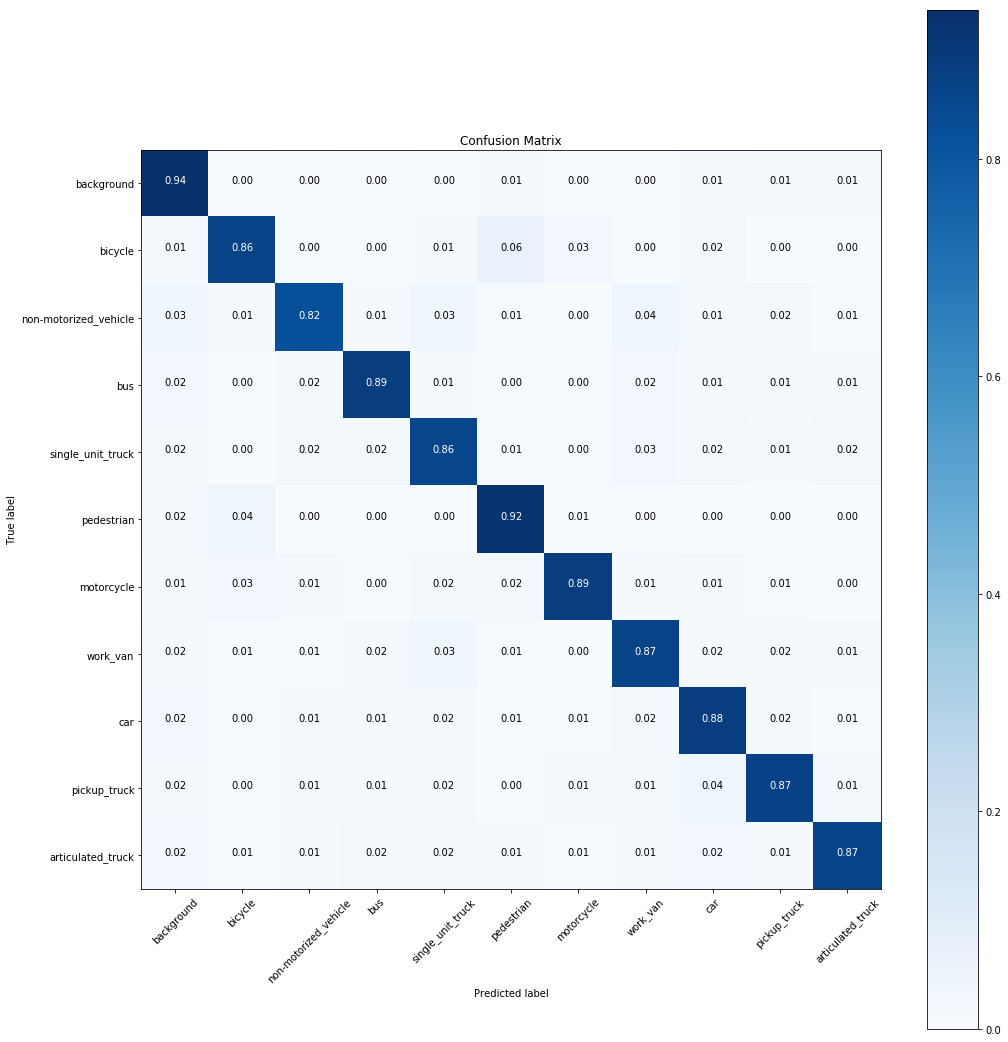

In [28]:
print('Accuracy Score:\t\t', metrics.accuracy_score(y_test, preds))
print('Standard Deviation:\t', metrics.explained_variance_score(y_test, preds))
plot_confusion_matrix(metrics.confusion_matrix(y_test, preds), 
                      classes=categories, 
                      title='Confusion Matrix', 
                      normalize=True)

In [ ]:
preds_again = svm_model.predict(X_test)

Happy with the accuracy score? Then you should save it.

In [49]:
dump(svm_model, 'models/SVM_classifier.joblib')

['models/SVM_classifier.joblib']

#### With extracted HoG features

In [17]:
gridsearch_estimate_hog = fine_tune_svm(X_train_hog[:120], y_train_hog[:120], folds=10)
print('SVM fit with parameters achieving highest accuracy:', gridsearch_estimate_hog.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   28.3s finished


SVM fit with parameters achieving highest accuracy: {'kernel': 'linear', 'C': 1, 'gamma': 0.001}


In [18]:
estimates_hog = gridsearch_estimate_hog.best_params_

svm_model_hog = svm.SVC(C=estimates_hog['C'], 
                        gamma=estimates_hog['gamma'], 
                        kernel=estimates_hog['kernel'])

svm_model_hog.fit(X_train_hog, y_train_hog)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

If you'd like, you can import the HoG SVM instead of training it.

In [19]:
svm_model_hog = load('models/SVM_classifier_hog.joblib')

In [20]:
preds_hog = svm_model_hog.predict(X_test_hog)

Accuracy Score:		 0.32
Standard Deviation:	 -0.4004485378291185
Normalized confusion matrix


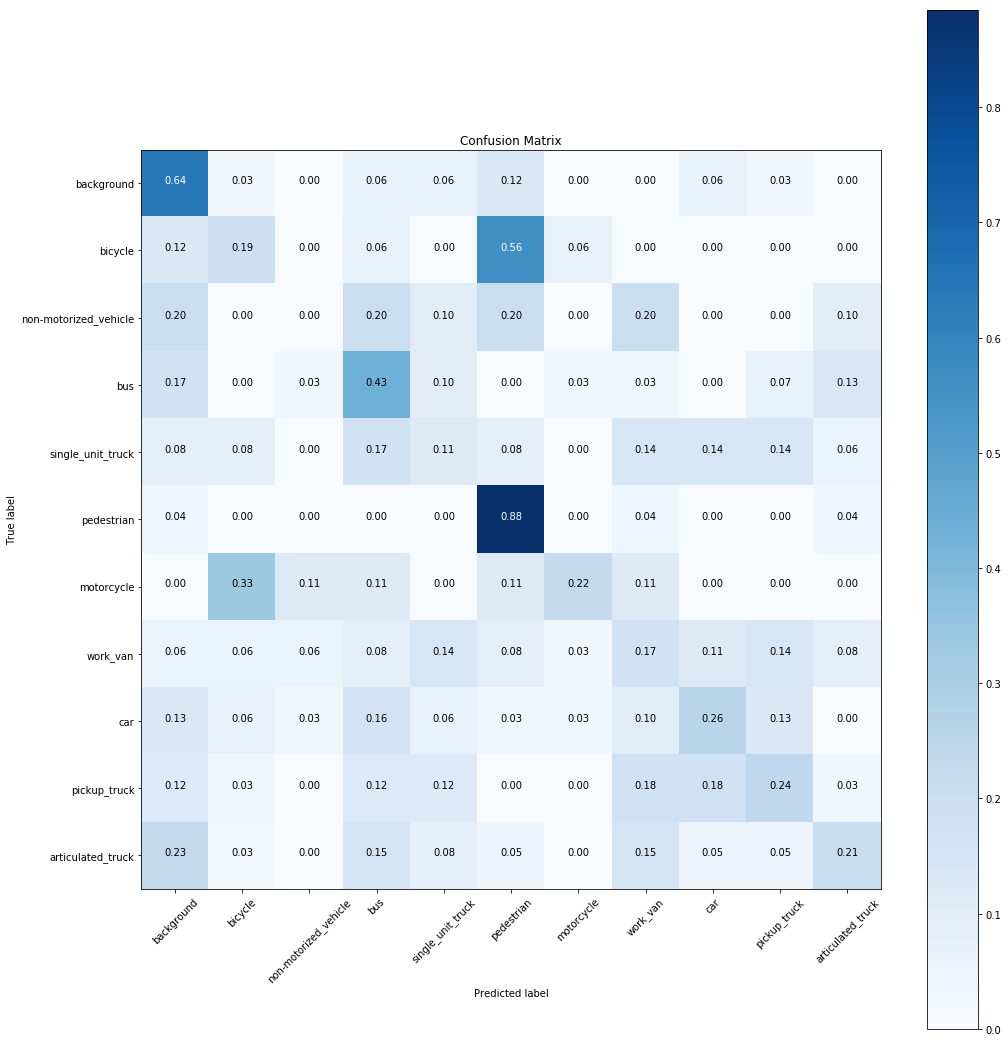

In [29]:
print('Accuracy Score:\t\t', metrics.accuracy_score(y_test_hog, preds_hog))
print('Standard Deviation:\t', metrics.explained_variance_score(y_test_hog, preds_hog))
plot_confusion_matrix(metrics.confusion_matrix(y_test_hog, preds_hog), 
                      classes=categories, 
                      title='Confusion Matrix', 
                      normalize=True)

In [21]:
dump(svm_model_hog, 'models/SVM_classifier_hog.joblib')

['models/SVM_classifier_hog.joblib']